# A quick starspot tutorial: measuring the rotation period of a TESS star

In this tutorial we'll measure the rotation period of a TESS target. First we'll download and plot a light curve using the lightkurve package.

In [1]:
import numpy as np
import lightkurve as lk

starname = "TIC 10863087"
lcf = lk.search_lightcurvefile(starname).download()

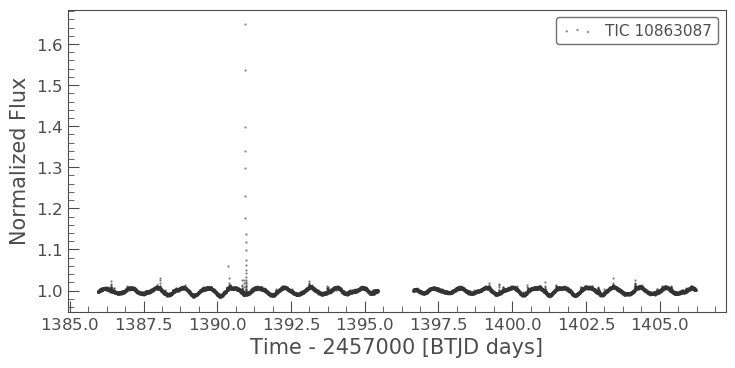

In [2]:
lc = lcf.PDCSAP_FLUX
lc.scatter(alpha=.5, s=.5);

First of all, let's remove the flares which will limit our ability to measure a rotation period by sigma clipping.

/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


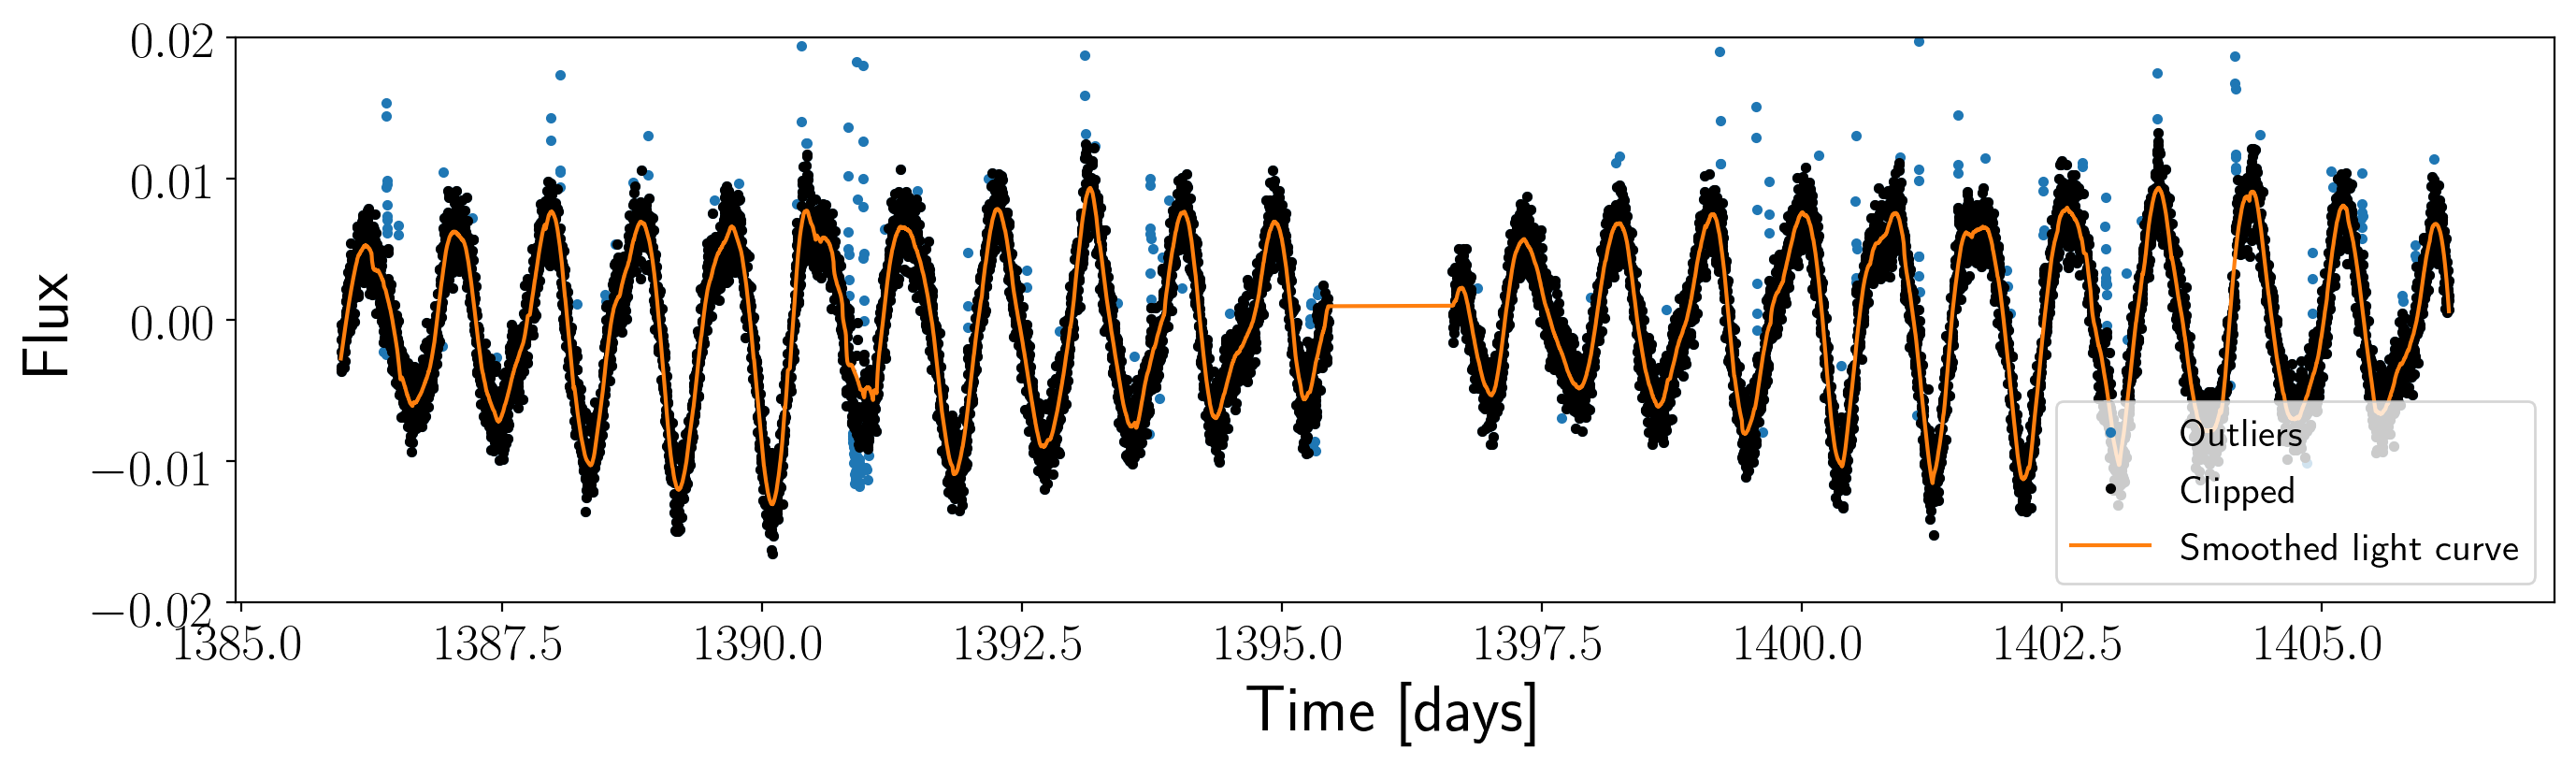

In [64]:
from starspot import sigma_clipping
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate the median so that we can median-normalize.
med = np.median(lc.flux)

# Do an initial sigma clip to remove big outliers.
m = sigma_clipping.sigma_clip(lc.flux/med - 1, nsigma=6)
x, y, yerr = lc.time[m], lc.flux[m]/med - 1, lc.flux_err[m]/med

# Then a sigma clip using a Sav-Gol filter for smoothing
smooth, mask = sigma_clipping.filter_sigma_clip(x, y, window_length=199)

time, flux, flux_err = x[mask], y[mask], yerr[mask]

plt.figure(figsize=(16, 4), dpi=200)
plt.plot(lc.time, lc.flux/med-1, ".", label="Outliers")
plt.plot(time, flux, "k.", label="Clipped")
plt.plot(x, smooth, label="Smoothed light curve")
plt.xlabel("Time [days]")
plt.ylabel("Flux");
plt.ylim(-.02, .02);
plt.legend(loc="lower right", fontsize=15);

Next, let's import starspot and set up a RotationModel object.

In [34]:
import starspot as ss

rotate = ss.RotationModel(time, flux, flux_err)

We can also plot the light curve using the lc_plot function in starspot:

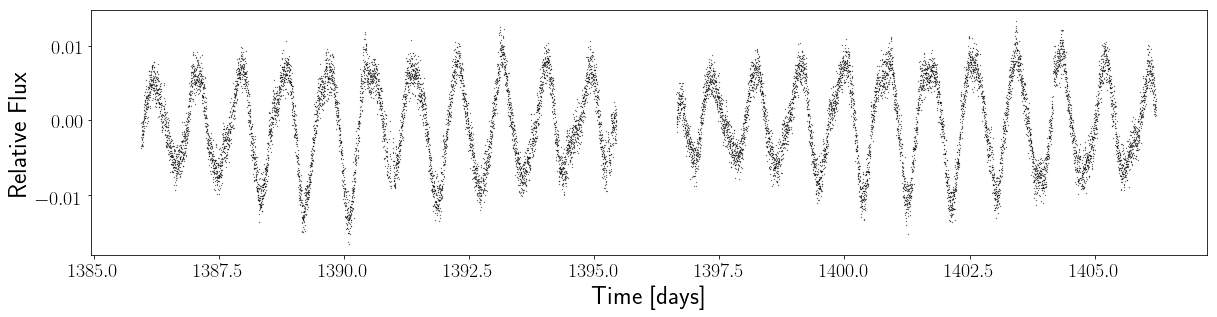

In [35]:
rotate.lc_plot()

Now let's measure a rotation period for this star using the astropy implementation of the Lomb-Scargle periodogram. This algorithm fits a single sinusoid to the light curve and reports the squared amplitude of the sinusoid over a range of frequencies (1/periods).

In [36]:
ls_period = rotate.ls_rotation()

In [37]:
ls_period

0.8608226895847505

We measured a rotation period of 0.86 days by finding the period of the highest peak in the periodogram. Let's plot the periodogram.

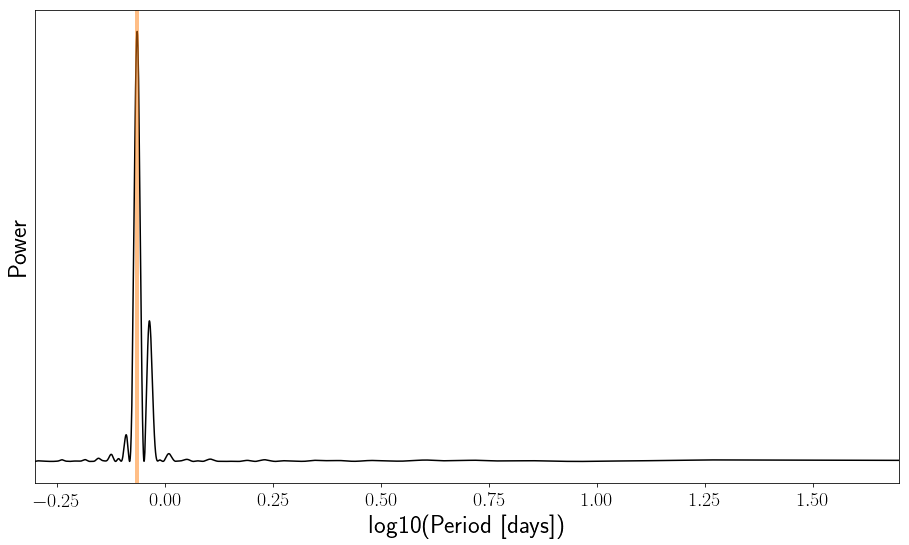

In [38]:
rotate.ls_plot();

Now let's calculate an ACF and measure a rotation period by finding the highest peak.

In [39]:
tess_cadence = 1./24./30.  # This is a TESS 2 minute cadence star.
acf_period = rotate.acf_rotation(tess_cadence)

In [40]:
acf_period

0.8749999999999999

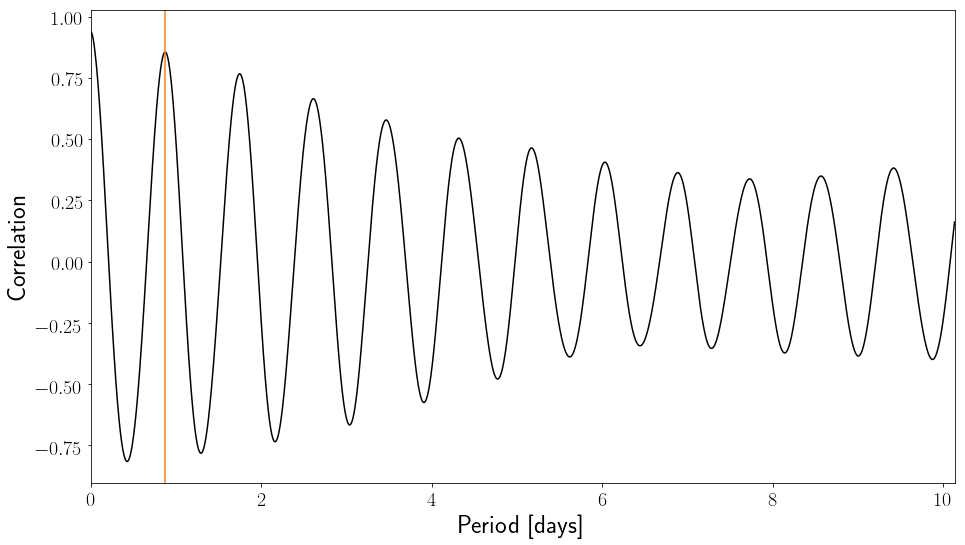

In [41]:
rotate.acf_plot();

This method estimates a period of 0.88 days, which is very close to the periodogram method. It is important to note that the LS periodogram method and the ACF method are not independent, i.e. if you measure a certain rotation period with one, you are likely to measure the same rotation period with the other. These two methods should not be used as independent 'checks' to validate a measured rotation period.

Now, let's calculate a rotation period using the Phase Dispersion Minimization algorithm of [Stellingwerf (1978)](https://ui.adsabs.harvard.edu/abs/1978ApJ...224..953S/abstract). This function will return the period with the lowest phase dispersion. It also fits a Gaussian to the dispersion curve in order to estimate the uncertainty. This Gaussian is shown in blue in the lower panel.

In [42]:
period_grid = np.linspace(.1, 2, 1000)
pdm_period, period_err = rotate.pdm_rotation(period_grid, pdm_nbins=10)  # Set the number of bins to 10
print(pdm_period, period_err)

100%|██████████| 1000/1000 [00:06<00:00, 159.11it/s]

0.8607607607607607 0.011651757899962235


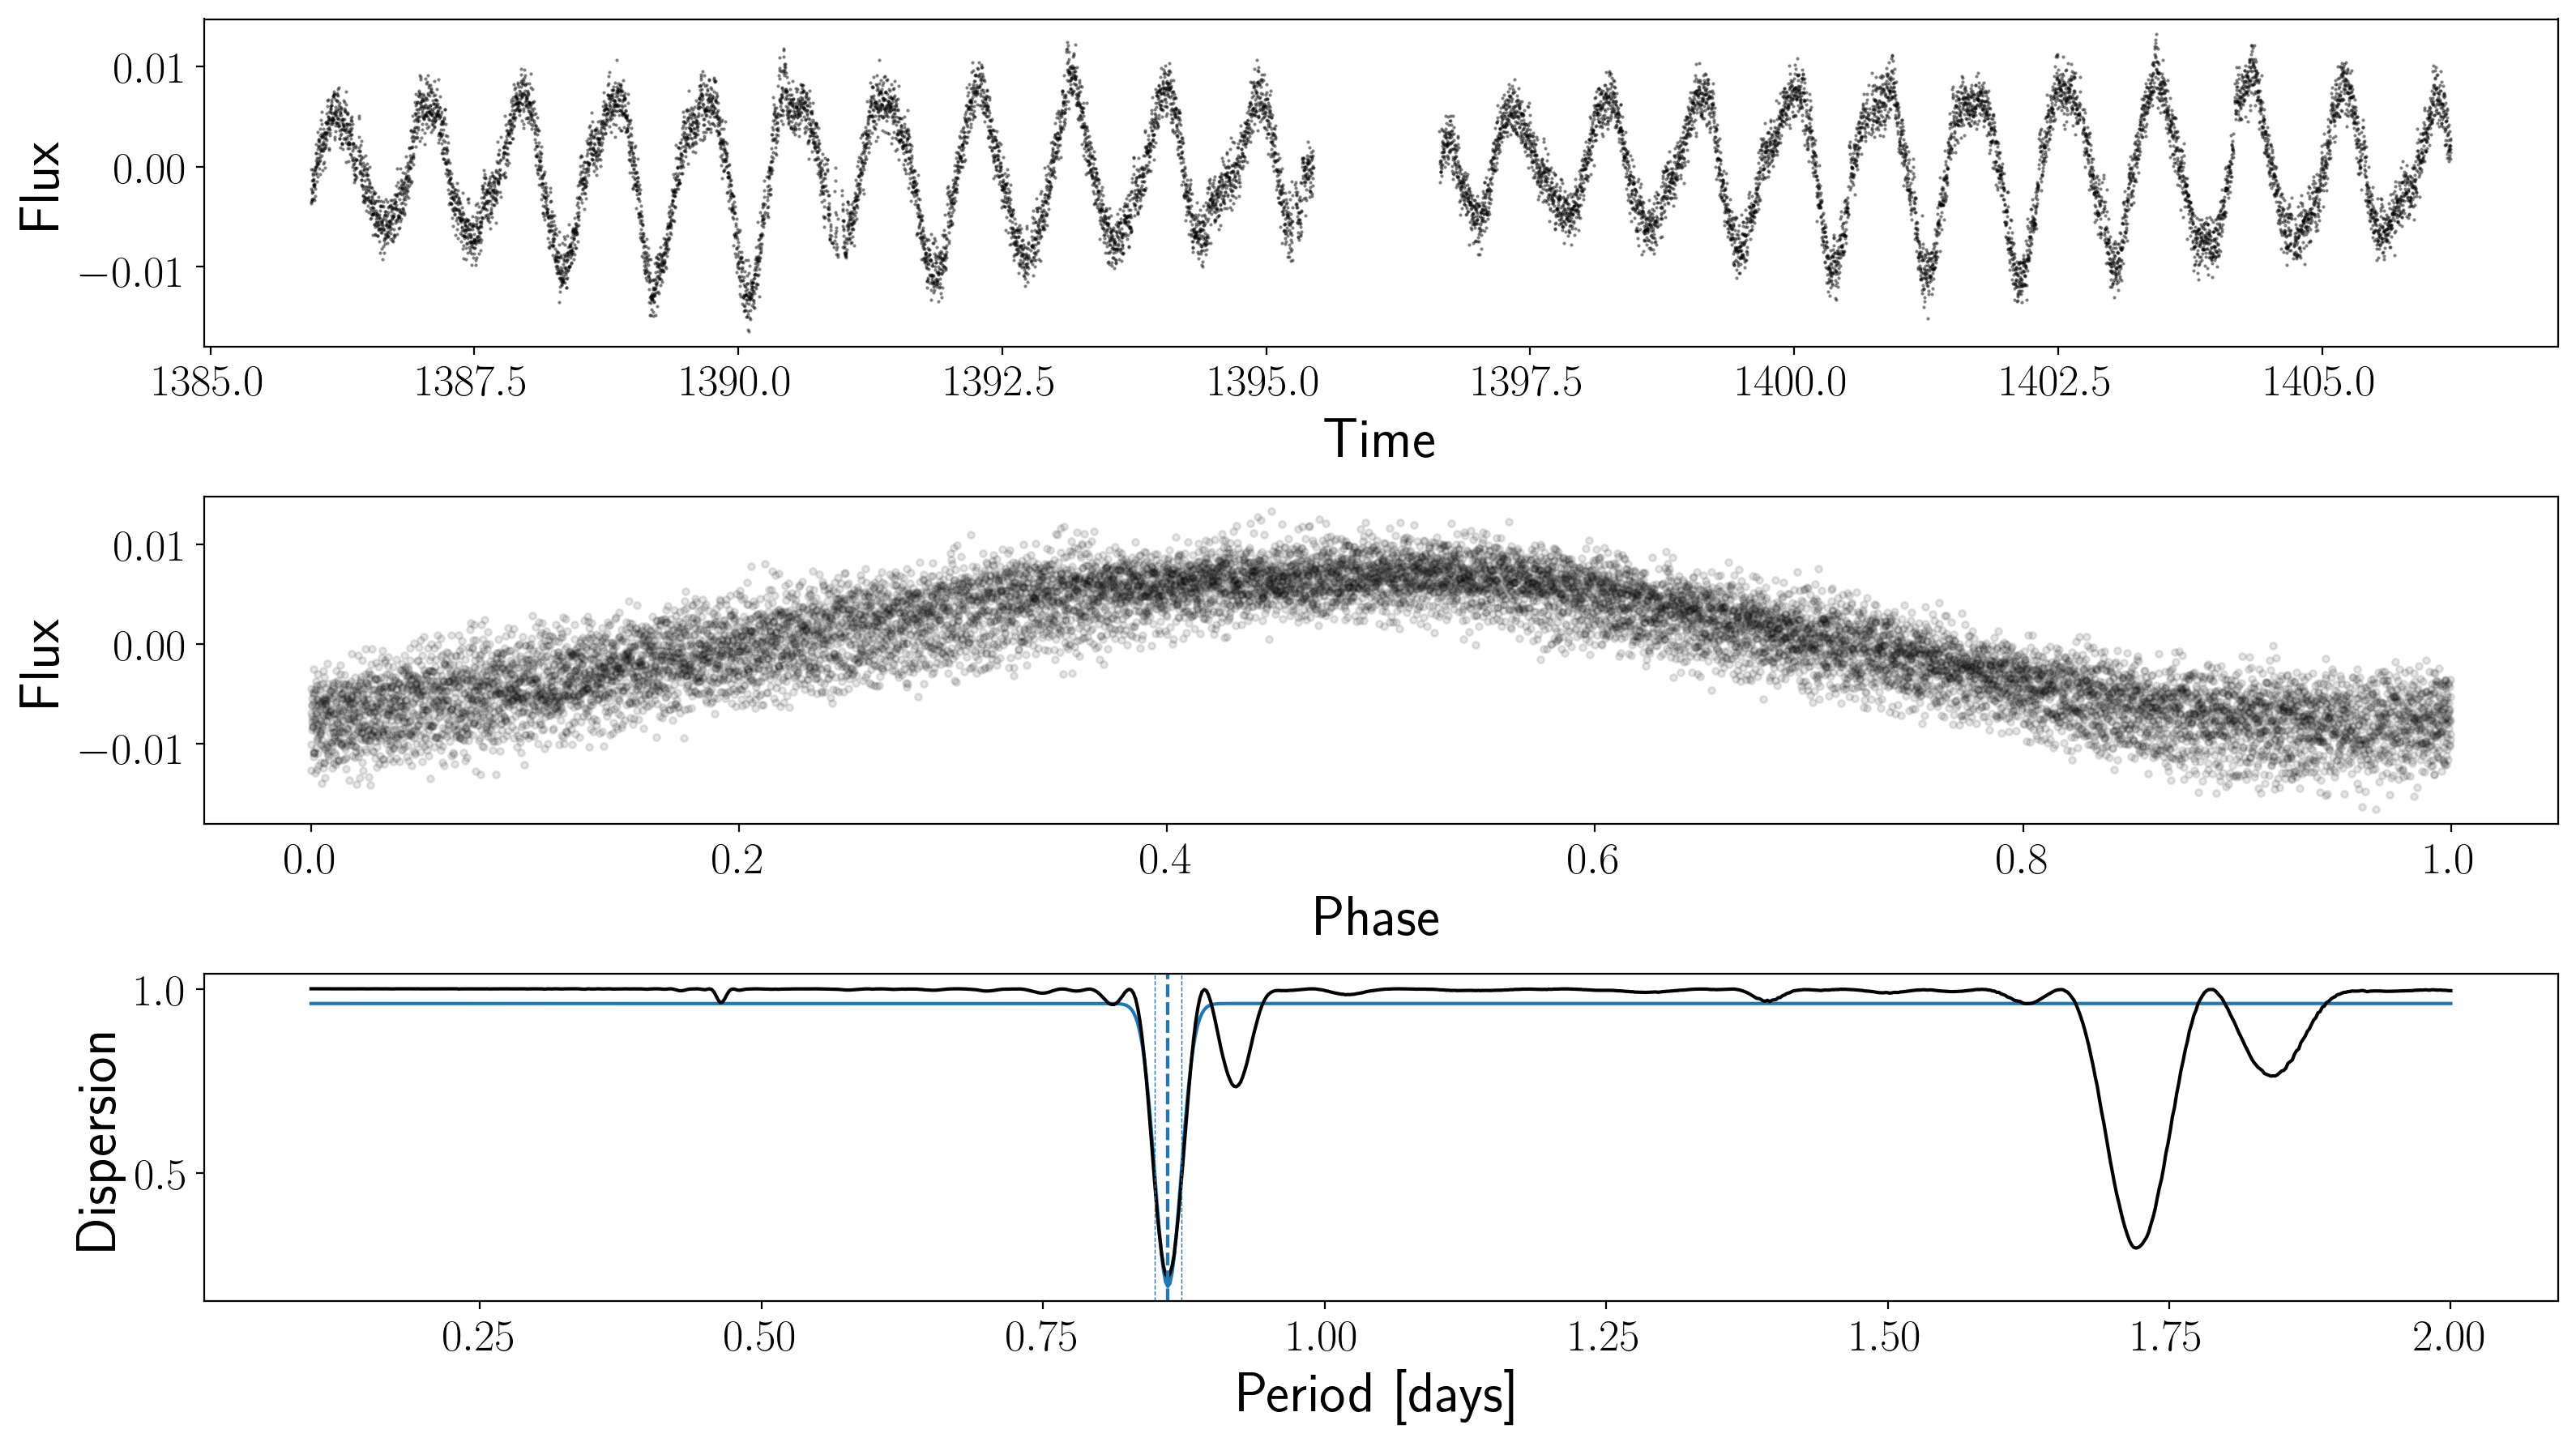

In [43]:
rotate.pdm_plot();

Now we can plot all these methods together in a single figure, with the light curve folded on the three different periods using big_plot:

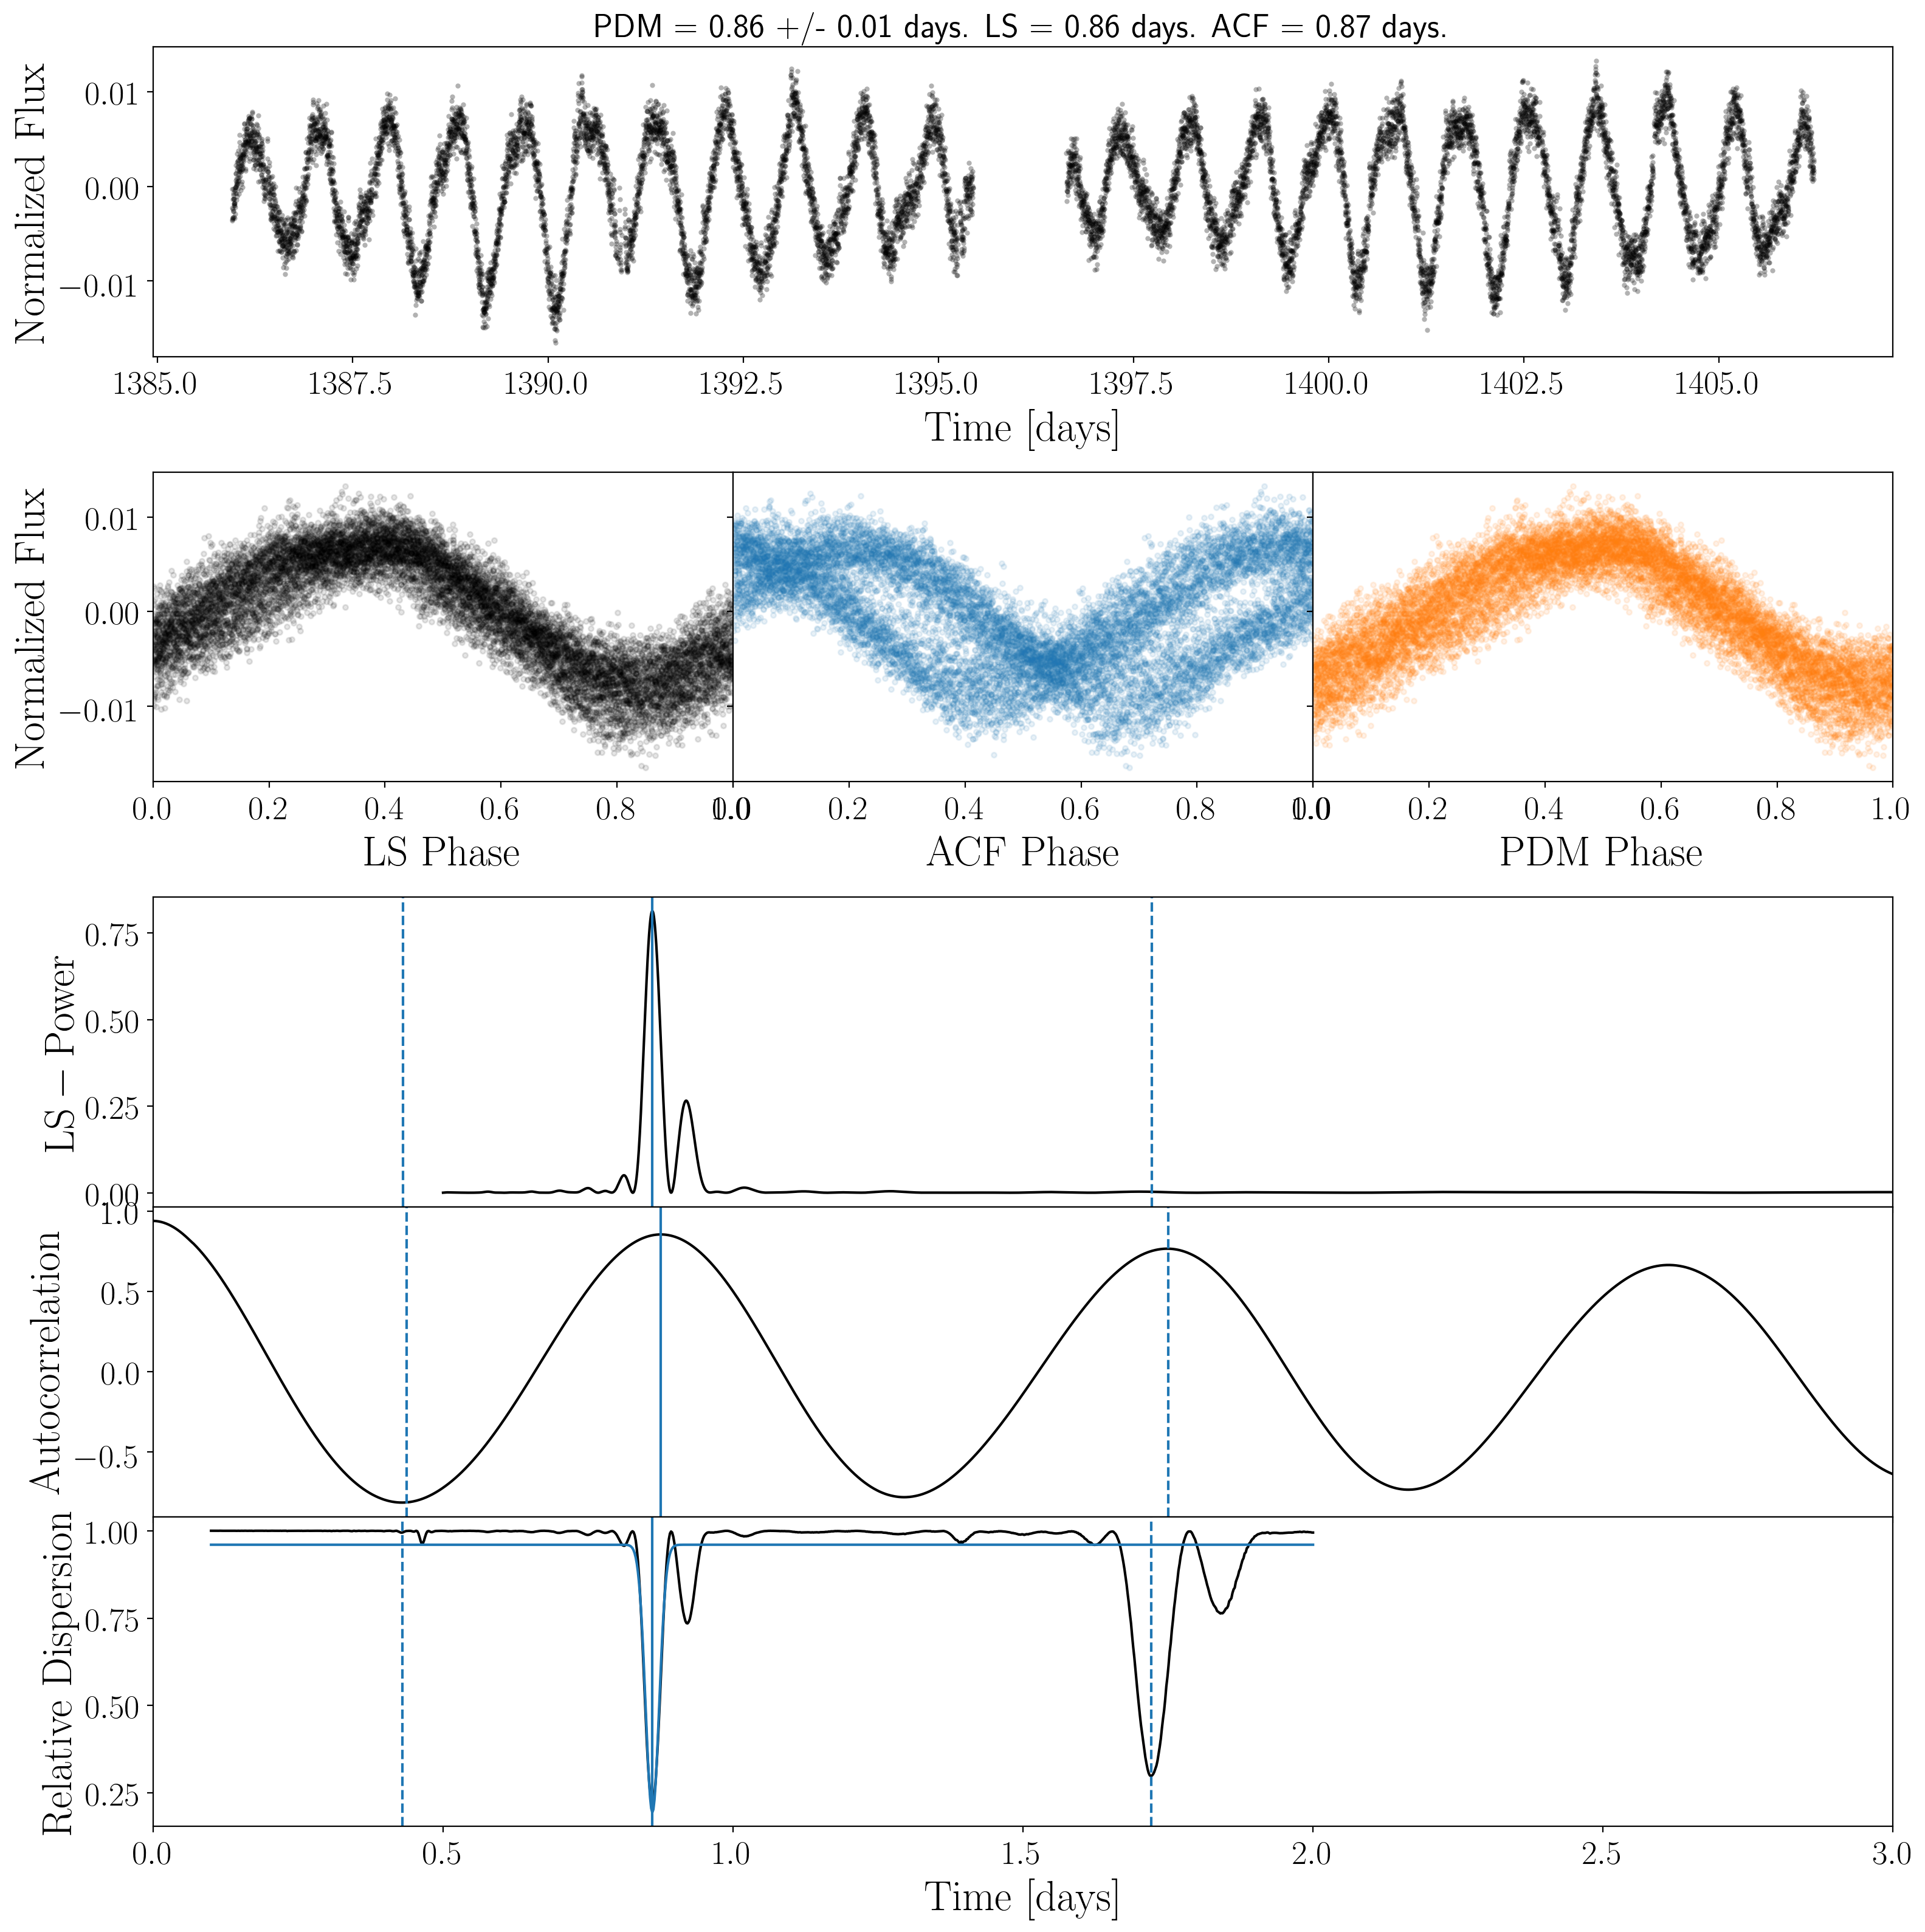

In [49]:
# Provide the list of methods and xlimits for the bottom panels
fig = rotate.big_plot(["ls", "acf", "pdm"], method_xlim=(0, 3));

The Lomb-Scargle periodogram, ACF, and phase dispersion arrays are accessible via:

In [14]:
# Lomb-Scargle periodogram
period_array = 1./rotate.freq
power_array = rotate.power

# Autocorrelation function
ACF_array = rotate.acf
lag_array = rotate.lags

# Phase-dispersion minimization
phi_array = rotate.phis  # The 'dispersion' plotted in the lower panel above.
period_grid = period_grid  # We already defined this above.

These could come in handy because it might be useful to calculate various peak statistics. We can do that with the get_peak_statistics() function in rotation_tools, e.g.

In [15]:
import starspot.rotation_tools as rt

# Get peak positions and heights, in order of highest to lowest peak. 
peak_positions, peak_heights = rt.get_peak_statistics(1./rotate.freq, rotate.power)
print(peak_positions[0]) # This is the period of the highest peak (which is the default LS period)

0.8607640045552087


For the ACF peak statistics, we might choose either the highest peak as the period (default in starrotate):

In [16]:
# Get peak positions and heights, in order of highest to lowest peak. 
acf_peak_positions, acf_peak_heights = rt.get_peak_statistics(rotate.lags, rotate.acf, sort_by="height")
prinjt(acf_peak_positions[0])

0.8763888888888888


Or the first peak:

In [17]:
# Get peak positions and heights, in order of lags. 
acf_peak_positions, acf_peak_heights = rt.get_peak_statistics(rotate.lags, rotate.acf, sort_by="position")
print(acf_peak_positions[0])

0.8763888888888888


In this example the first and the highest peak are the same.

Finally, let's measure a rotation period with the exoplanet implementation of a celerite Gaussian process. This part takes a little while to run.

In [18]:
gp_results = rotate.gp_rotation()

success: True
initial logp: -57586.82016285792
final logp: -56551.71904925596
sampling...


Sampling 4 chains: 100%|██████████| 208/208 [00:09<00:00, 21.09draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]
Sampling 4 chains: 100%|██████████| 8000/8000 [03:18<00:00, 40.36draws/s]


We can print the resulting GP rotation period and its associated uncertainties:

In [19]:
print("GP period j= {0:.2f} + {1:.2f} - {2:.2f}".format(rotate.gp_period, rotate.errp, rotate.errm))

GP period = 0.81 + 0.02 - 0.02


And plot the posterior PDF:

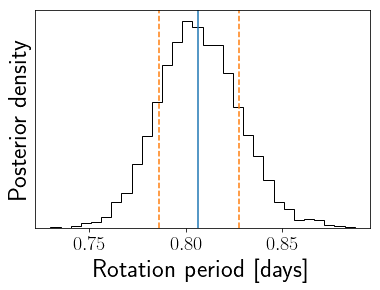

In [20]:
rotate.plot_posterior()

We can also plot this manually:

Text(0, 0.5, 'Unnormalized probability')

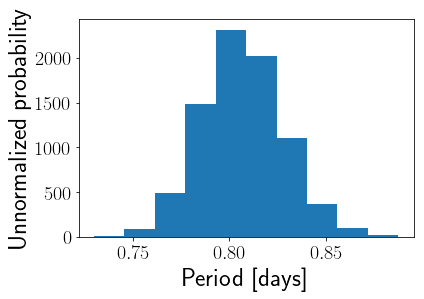

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(rotate.period_samples);
plt.xlabel("Period [days]")
plt.ylabel("Unnormalized probability")

And we can plot the posterior prediction:

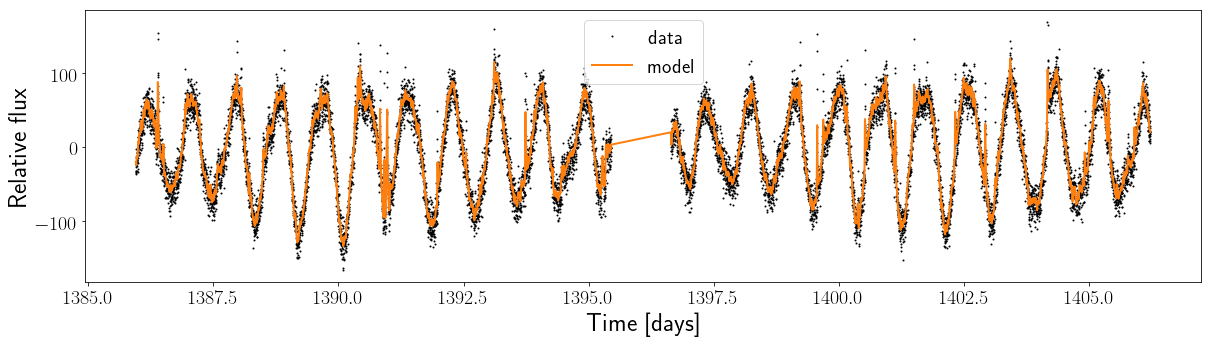

In [22]:
rotate.plot_prediction()

You can see that there are still outliers in the light curve produced by flares which is affecting the GP fit. A better outlier removal algorithm would improve this fit!